In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from model import PermutationModel
import numpy as np
import seaborn as sns

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [3]:
## grid 
num_bins = 1000
x = torch.linspace(0, 1, steps=num_bins)

In [4]:
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
loss_type_to_criterion = {
    'cross_entropy': nn.NLLLoss(),
    'L2': nn.MSELoss(),
    'L1': nn.L1Loss(),
    'kl_divergence': nn.KLDivLoss(reduction='batchmean'), ## double check why we need to use reduction='batchmean'
}
# 
loss_type = 'L2'
criterion = loss_type_to_criterion[loss_type]

In [5]:
#### perm on prediction
label = torch.tensor([0])


In [6]:
grad_norm_vec = torch.zeros_like(x)

In [7]:
def get_grad_norm_vec_perm_on_pred(x, alpha_max):
    perm_model = PermutationModel(2, label, alpha_max)
    optim = torch.optim.SGD(perm_model.parameters(), lr=1)
    y = 1-x
    for i in range(num_bins):
        optim.zero_grad()
        prediction = torch.tensor([x[i],y[i]]).type(torch.float32)
        permuted_logits = perm_model(prediction, label, [0], logits_softmax_mode=None) # try log_perm_softmax
        if loss_type == 'cross_entropy':
            loss = criterion(torch.log(permuted_logits), label)
        elif loss_type == 'kl_divergence':
            loss = criterion(torch.log(permuted_logits), torch.nn.functional.one_hot(label, num_classes=2).type(torch.float32))
        else:
            loss = criterion(permuted_logits, torch.nn.functional.one_hot(label, num_classes=2).type(torch.float32))
        loss.backward()
        grad_norm = perm_model.alpha_matrix.grad.norm()
        grad_norm_vec[i] = grad_norm
    return grad_norm_vec

In [8]:
def get_grad_norm_vec_perm_on_label(x, alpha_max):
    one_hot_label = torch.nn.functional.one_hot(label, num_classes=2).type(torch.float32)
    perm_model = PermutationModel(2, label, alpha_max)
    optim = torch.optim.SGD(perm_model.parameters(), lr=1)
    y = 1-x
    for i in range(num_bins):
        optim.zero_grad()
        prediction = torch.tensor([x[i],y[i]]).type(torch.float32)
        permuted_label = perm_model(one_hot_label, label, [0], logits_softmax_mode=None) # try log_perm_softmax
        if loss_type == 'cross_entropy':
            raise NotImplemented
            # loss = criterion(torch.log(permuted_logits), label)
        elif loss_type == 'kl_divergence':
            loss = criterion(prediction, permuted_label)
        else:
            loss = criterion(prediction, permuted_label)
        loss.backward()
        grad_norm = perm_model.alpha_matrix.grad.norm()
        grad_norm_vec[i] = grad_norm
    return grad_norm_vec

In [152]:
colors_rocket = sns.color_palette("rocket",8)
colors = sns.color_palette()
grey_color = sns.color_palette("tab10")[-3]

colors


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [153]:
colors_rocket

[(0.16342174, 0.0851396, 0.21088893),
 (0.33067031, 0.11701189, 0.30632563),
 (0.51728314, 0.1179558, 0.35453252),
 (0.70457834, 0.0882129, 0.34473046),
 (0.86641628, 0.17387796, 0.27070818),
 (0.94291042, 0.37549479, 0.26369821),
 (0.96173392, 0.57988594, 0.41844491),
 (0.96656022, 0.75658231, 0.62527295)]

In [156]:
colors = [colors[0], colors[1], colors_rocket[1]]

In [157]:
# colors = ["#165374", "#ba5900", colors_rocket[1]]

2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/miniforge3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users

tensor(0.1328)


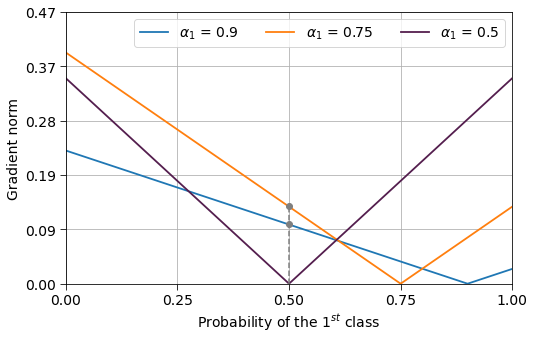

In [158]:
# plt.style.use(['science'])
plt.rcParams['font.size']=14
fig, ax = plt.subplots(figsize=(8,5))
alpha_max_list = [0.9, 0.75, 0.5]
vertical_line_intercepts = []
for i, alpha_max in enumerate(alpha_max_list):
    grad_norm_vec = get_grad_norm_vec_perm_on_label(x, alpha_max)
    ax.plot(x, grad_norm_vec, label = r"$\alpha_{1}$ = " + f"{alpha_max}", color=colors[i], linewidth=1.8, zorder=2)
    indx, _ = find_nearest(x, 0.5)
    vertical_line_intercepts.append(grad_norm_vec[indx].clone())
    if grad_norm_vec[indx] > 0.001:
        ax.scatter(0.5, grad_norm_vec[indx], color=grey_color, zorder=4)
ax.legend(ncol=3)

# ax.scatter(0.5, grad_norm_vec[indx], color=grey_color)
ax.set_ylim((0,ax.get_ylim()[1]+0.05))
ax.set_xticks(np.linspace(0.0, 1.0, 5))
ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 6))
ax.set_xlim((0,1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(zorder=1)
print(max(vertical_line_intercepts))
ax.axvline(x=0.5, ls='--', color=grey_color, zorder=3, ymax=(max(vertical_line_intercepts).item()-ax.get_ylim()[0])/ax.get_ylim()[1])


# alpha_max_list = [0.85, 0.8, 0.7, 0.65, 0.6, 0.55]
# alpha_max_list = [0.825, 0.583, 0.666]
# for i, alpha_max in enumerate(alpha_max_list):
#     grad_norm_vec = get_grad_norm_vec_perm_on_label(x, alpha_max)
#     ax.plot(x, grad_norm_vec, color=grey_color, linewidth=1.8, zorder=2, alpha=0.2)
#     indx, _ = find_nearest(x, 0.5)
# ax.legend(ncol=3)



ax.set_ylabel("Gradient norm")
ax.set_xlabel(r"Probability of the $1^{st}$ class")

plt.tick_params(direction='out',which='major', length=6)
plt.savefig('perm_on_label_l2.eps', format='eps', bbox_inches="tight")
# plt.legend([r"$\alpha_{max}$ = " + f"{x}" for x in alpha_max_list])

2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
The PostScript backend does not support transparency; partial

tensor(0.0004)


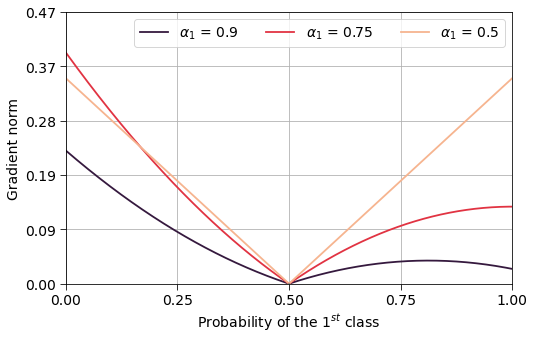

In [136]:
# plt.style.use(['science'])
plt.rcParams['font.size']=14
fig, ax = plt.subplots(figsize=(8,5))
alpha_max_list = [0.9, 0.75, 0.5]
vertical_line_intercepts = []
for i, alpha_max in enumerate(alpha_max_list):
    grad_norm_vec = get_grad_norm_vec_perm_on_pred(x, alpha_max)
    ax.plot(x, grad_norm_vec, label = r"$\alpha_{1}$ = " + f"{alpha_max}", color=colors[i], linewidth=1.8, zorder=2)
    indx, _ = find_nearest(x, 0.5)
    vertical_line_intercepts.append(grad_norm_vec[indx].clone())
    if grad_norm_vec[indx] > 0.001:
        ax.scatter(0.5, grad_norm_vec[indx], color=grey_color, zorder=4)
ax.legend(ncol=3)

# ax.scatter(0.5, grad_norm_vec[indx], color=grey_color)
ax.set_ylim((0,ax.get_ylim()[1]+0.05))
ax.set_xticks(np.linspace(0.0, 1.0, 5))
ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 6))
ax.set_xlim((0,1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(zorder=1)
print(max(vertical_line_intercepts))
ax.axvline(x=0.5, ls='--', color=grey_color, zorder=3, ymax=(max(vertical_line_intercepts).item()-ax.get_ylim()[0])/ax.get_ylim()[1])


# alpha_max_list = [0.85, 0.8, 0.7, 0.65, 0.6, 0.55]
# alpha_max_list = [0.825, 0.583, 0.666]
# for i, alpha_max in enumerate(alpha_max_list):
#     grad_norm_vec = get_grad_norm_vec_perm_on_pred(x, alpha_max)
#     ax.plot(x, grad_norm_vec, color=grey_color, linewidth=1.8, zorder=2, alpha=0.2)
#     indx, _ = find_nearest(x, 0.5)
# ax.legend(ncol=3)



ax.set_ylabel("Gradient norm")
ax.set_xlabel(r"Probability of the $1^{st}$ class")

plt.tick_params(direction='out',which='major', length=6)
plt.savefig('perm_on_pred_l2.eps', format='eps', bbox_inches="tight")
# plt.legend([r"$\alpha_{max}$ = " + f"{x}" for x in alpha_max_list])

2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/miniforge3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users

2.1972246170043945
1.0986123085021973
0.0


/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value
/Users/salman/Research/noisy_labels/NLLP/model.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  1, torch.tensor(targets).unsqueeze(1), self.perm_init_value


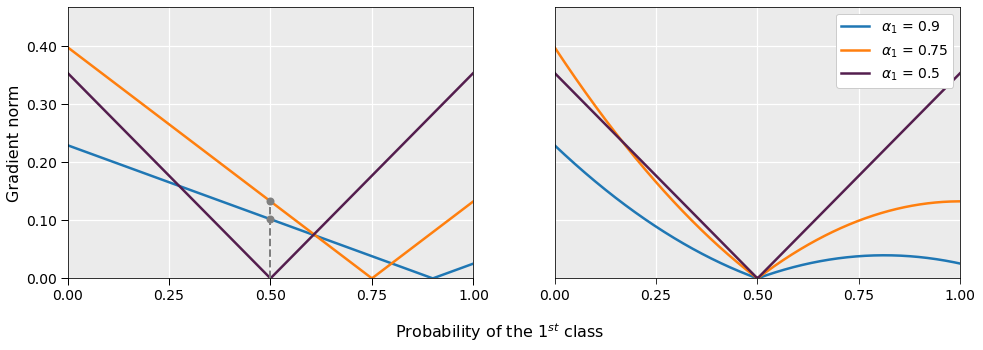

In [188]:
# plt.style.use(['science'])
plt.rcParams['font.size']=14
fig, ax = plt.subplots(1,2, figsize=(16,5))

ax[0].set_facecolor('#EBEBEB')
ax[0].grid(which='major', color='white', linewidth=1.2)
ax[0].grid(which='minor', color='white', linewidth=0.6)

ax[1].set_facecolor('#EBEBEB')
ax[1].grid(which='major', color='white', linewidth=1.2)
ax[1].grid(which='minor', color='white', linewidth=0.6)

ax[0].tick_params('both', length=7, width=1, which='major')


alpha_max_list = [0.9, 0.75, 0.5]
vertical_line_intercepts = []
for i, alpha_max in enumerate(alpha_max_list):
    grad_norm_vec = get_grad_norm_vec_perm_on_label(x, alpha_max)
    ax[0].plot(x, grad_norm_vec, label = r"$\alpha_{1}$ = " + f"{alpha_max}", color=colors[i], linewidth=2.5, zorder=2)
    indx, _ = find_nearest(x, 0.5)
    vertical_line_intercepts.append(grad_norm_vec[indx].clone())
    if grad_norm_vec[indx] > 0.001:
        ax[0].scatter(0.5, grad_norm_vec[indx], color=grey_color, linewidth=2, zorder=4)

# ax.scatter(0.5, grad_norm_vec[indx], color=grey_color)
ax[0].set_ylim((0,ax[0].get_ylim()[1]+0.05))
ax[0].set_xticks(np.linspace(0.0, 1.0, 5))
# ax[0].set_yticks(np.linspace(0, ax[0].get_ylim()[1], 6))
ax[0].set_xlim((0,1))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[0].grid(zorder=1)
ax[0].axvline(x=0.5, ls='--', color=grey_color, linewidth=2, zorder=3, ymax=(max(vertical_line_intercepts).item()-ax[0].get_ylim()[0])/ax[0].get_ylim()[1])


# alpha_max_list = [0.85, 0.8, 0.7, 0.65, 0.6, 0.55]
# alpha_max_list = [0.825, 0.583, 0.666]
# for i, alpha_max in enumerate(alpha_max_list):
#     grad_norm_vec = get_grad_norm_vec_perm_on_label(x, alpha_max)
#     ax.plot(x, grad_norm_vec, color=grey_color, linewidth=1.8, zorder=2, alpha=0.2)
#     indx, _ = find_nearest(x, 0.5)
# ax.legend(ncol=3)


# plt.style.use(['science'])
alpha_max_list = [0.9, 0.75, 0.5]
vertical_line_intercepts = []
for i, alpha_max in enumerate(alpha_max_list):
    grad_norm_vec = get_grad_norm_vec_perm_on_pred(x, alpha_max)
    ax[1].plot(x, grad_norm_vec, label = r"$\alpha_{1}$ = " + f"{alpha_max}", color=colors[i], linewidth=2.5, zorder=2)
    indx, _ = find_nearest(x, 0.5)
    vertical_line_intercepts.append(grad_norm_vec[indx].clone())
    if grad_norm_vec[indx] > 0.001:
        ax.scatter(0.5, grad_norm_vec[indx], color=grey_color, zorder=4)
ax[1].legend(ncol=1, loc='upper right', framealpha=1)
#  fancybox=True,

# ax.scatter(0.5, grad_norm_vec[indx], color=grey_color)
ax[1].set_ylim((0,ax[1].get_ylim()[1]+0.05))
ax[1].set_xticks(np.linspace(0.0, 1.0, 5))
# ax[1].set_yticks(np.linspace(0, ax[1].get_ylim()[1], 6))
ax[1].set_xlim((0,1))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1].grid(zorder=1)


# alpha_max_list = [0.85, 0.8, 0.7, 0.65, 0.6, 0.55]
# alpha_max_list = [0.825, 0.583, 0.666]
# for i, alpha_max in enumerate(alpha_max_list):
#     grad_norm_vec = get_grad_norm_vec_perm_on_pred(x, alpha_max)
#     ax.plot(x, grad_norm_vec, color=grey_color, linewidth=1.8, zorder=2, alpha=0.2)
#     indx, _ = find_nearest(x, 0.5)
# ax.legend(ncol=3)



ax[0].set_ylabel("Gradient norm", size=16)
# ax.set_xlabel(r"Probability of the $1^{st}$ class")
fig.text(0.5, -0.04, "Probability of the $1^{st}$ class", ha='center', size=16)
ax[1].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    labelleft=False) # labels along the bottom edge are off

plt.tick_params(direction='out',which='major', length=6)
plt.savefig('both_l2.eps', format='eps', bbox_inches="tight")
plt.savefig('both_l2.png', format='png', dpi=600, bbox_inches="tight")

# plt.legend([r"$\alpha_{max}$ = " + f"{x}" for x in alpha_max_list])